## 0. Goldreich and Kwan (1974, ApJ 189, 441) 공식 유도

#### statistical quilibrium에 의해
#### $\frac{d}{dt} n_{i} = \sum\limits_{j\neq i} n_{j}P_{ji} - n_{i}\sum\limits_{j\neq i}
P_{ij} = 0$ ,  $P_{ij}$: transition rate

#### $P_{ij} = A_{ij} + B_{ij} + n_{e}C_{ij}$
#### $A_{ij}, B_{ij}: Radiation$
#### $n_{e}C_{ij: Collision}$

#### 복사는 인접한 에너지 준위에서만, 충돌은 모든 에너지 준위 사이에서 나타날 수 있으므로, 각각의 효과를 따로 나타내면,

#### $0 = \sum_{}$

#### $0 = \beta_{j+1, j}A_{j+1, j}\frac{2j+3}{2j+1}(n_{j+1} - \frac{n_{j} - n_{j+1}}{exp(2hB(j+1))/kT_{BB} - 1}) - \beta_{j, j-1}A_{j, j-1}(n_{j} - \frac{n_{j-1} - n_{j}}{exp(2hBj)/kT_{BB} - 1}) + C[\sum\limits_{l = j+1}^{\infty}(2l+1)(n_{l} - n_{j}exp(\frac{hB}{kT}(j(j+1) - l(l+1)))) - \sum\limits_{l = 0}^{\infty}(j-1)(n_{j} - n_{l}exp(\frac{hB}{kT}(l(l+1) - j(j
+1))))]$ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N_co =  3e-5 * 2e4
mu = 0.1 * 1e-18 # cgs
R = 5 * 3.086e+18 #from pc to cm
V = 30 *1e5 #km/s to cm/s
h = 6.6261 * 1e-27 #cm2 g s-1
k_b = 1.3807e-16 #cm2 g s-2 K-1
B = 5.76e10 #Hz
Tbb = 2.73 #k
c = 3e10 #cm/s

T = 25 + 273 #k
C = 2e4 * 7e-12 * T**(1/2)
A =16 * h * B**3 / c**2 * 32 * np.pi**4 * mu*2/3/h**2/c * 1/3
TAU = 8 * np.pi**3 *mu**2 * R * N_co /(3*h*V)

In [3]:
Js = np.arange(0, 11, 1)

#table에서 주어진 값
n_js_table = np.array([0.1092, 0.0873, 0.0558, 0.0285, 0.0115, 0.0035, 0.00062, 0.000047, 0.0000034, 0.0000003, 0])
tau_table = np.array([8.46, 24.29, 31.61, 26.25, 15.53, 6.57, 1.56, 0.14, 0.011, 0.0011])
text_table = np.array([24.72, 24.77, 24.74, 24.42, 23.06, 19.39, 15.04, 16.77, 20.75, 21.21])

## 1. Level population
#### eq (5): $\beta_{j+1, j} = [1 - exp(-\tau_{j+1, j})]/\tau_{j+1, j}$

####  eq (7): $\tau_{j+1, j} = TAU(J+1)[n_{J} - n_{J+1}]$, $TAU=\frac{8\pi^{2}\mu^{2}RN_{CO}}{3hV}$  

#### eq (11): $0 = \beta_{j+1, j}\frac{(j+1)^{4}}{2j+1}(n_{j+1} - \frac{n_{j} - n_{j+1}}{exp(2hB(j+1))/kT_{BB} - 1}) - \beta_{j, j-1}\frac{(j)^{4}}{2j+1}(n_{j} - \frac{n_{j-1} - n_{j}}{exp(2hBj)/kT_{BB} - 1}) + \frac{C}{3A_{1,0}}[\sum\limits_{l = j+1}^{\infty}(2l+1)(n_{l} - n_{j}exp(\frac{hB}{kT}(j(j+1) - l(l+1)))) - \sum\limits_{l = 0}^{\infty}(j-1)(n_{j} - n_{l}exp(\frac{hB}{kT}(l(l+1) - j(j
+1))))]$ 

#### 식 5, 7, 11 을 조합하여 gauss-newton method를 사용해서 $n_{j}$의 값을 계산할 것이다.

In [4]:
import sympy as sp

#### 계산의 편의를 위해 먼저 구하고자 하는 $n_{j}$를 변수로 설정한다.

In [5]:
ns = []
for i in range(len(Js)):
    n = sp.Symbol(f'n{i}')
    ns.append(n)

#### 주어진 quantum state J에  따라 eq 5, 7, 11을 계산할 수 있는 함수를 정의한다.

In [6]:
#equation 5
def find_beta(J): #j+1,j
    tau = TAU * (J+1) * (ns[J] - ns[J+1])
    b = (1 - sp.exp(-tau))/tau
    return b

In [7]:
def sum1(J):
    sum1 = 0
    for i in range(J+1, 11):
        sum1 += (2*i + 1) * (ns[i] - ns[J] * sp.exp(h*B/k_b/T*(J*(J+1) - i*(i+1))))

    return sum1

def sum2(J):
    sum2 = 0
    for i in range(0, J):
        sum2 += (2*i + 1) * (ns[J] - ns[i] * sp.exp(h*B/k_b/T*(i*(i+1) - J*(J+1))))
        
    return -1 * sum2

In [8]:
#eq 11
def find_eq(J):
        
    if J < 1:
        b0 = find_beta(J)
        eq = b0 * (J+1)**4/(2*J+1) * (ns[J+1] - (ns[J] - ns[J+1])/(sp.exp(2*h*B*(J+1)/(k_b*Tbb)) - 1))+  2.17 * T**(-1.2) *sum1(J)

    elif J > 9:
        b1 = find_beta(J-1)
        eq = - b1 * J**4/(2*J+1) * (ns[J] - (ns[J-1] - ns[J])/(sp.exp(2*h*B*J/(k_b*Tbb)) - 1))+  2.17 * T**(-1.2) * sum2(J)

    else:
        b0 = find_beta(J)
        b1 = find_beta(J-1)
        eq = b0 * (J+1)**4/(2*J+1) * (ns[J+1] - (ns[J] - ns[J+1])/(sp.exp(2*h*B*(J+1)/(k_b*Tbb)) - 1))- b1 * J**4/(2*J+1) * (ns[J] - (ns[J-1] - ns[J])/(sp.exp(2*h*B*J/(k_b*Tbb)) - 1)) + 2.17 * T**(-1.2)* (sum1(J) + sum2(J))

    return eq


#### F = $\left[\begin{array}{rrr} 
f_{j = 0}\\
.\\
.\\
.\\
f_{j = 10}
\end{array}\right]$

#### J = $\left[\begin{array}{rrr} 
\frac{df_{j=0}}{dn_{j=0}}&...&\frac{df_{j=0}}{dn_{j=10}}\\
.&.&.\\
\frac{df_{j=10}}{dn_{j=0}}&...&\frac{df_{j=10}}{dn_{j=10}}
\end{array}\right]$

In [9]:
#equation
f_list = []
for i in range(len(Js)):
    f_list.append(find_eq(i))
    
F = sp.Matrix(f_list)

In [10]:
#jacobian
j_list = []
for i in range(len(Js)):
    j_list2 = []  
    eq = find_eq(i)
    for k in range(len(Js)):
        j_list2.append(sp.diff(eq, ns[k]))
    
    j_list.append(j_list2)
Jac = sp.Matrix(j_list)

#### 초기 값을 설정한다. 이때 Newton method 특성상 초기 조건이 해와 크게 달라지면 발산하거나 다른 해를 찾을 수 있어 유의하여 초기값을 설정한다.

In [11]:
# X_in = np.logspace(-0.1, -7, 11)
# X_in = np.logspace(-0.1, -7, 11)
X_in = np.logspace(-0.1, -6, 11)
X_in

array([7.94328235e-01, 2.04173794e-01, 5.24807460e-02, 1.34896288e-02,
       3.46736850e-03, 8.91250938e-04, 2.29086765e-04, 5.88843655e-05,
       1.51356125e-05, 3.89045145e-06, 1.00000000e-06])

In [12]:
#list to dictionary
X_init = {ns[i]: X_in[i] for i in range(len(Js))}
print(X_init)

{n0: 0.7943282347242815, n1: 0.2041737944669529, n2: 0.05248074602497723, n3: 0.013489628825916526, n4: 0.003467368504525313, n5: 0.000891250938133745, n6: 0.00022908676527677702, n7: 5.888436553555884e-05, n8: 1.5135612484362071e-05, n9: 3.890451449942805e-06, n10: 1e-06}


In [13]:
F.subs(X_init)

Matrix([
[  -0.130403673664045],
[ -0.0290869540608262],
[-0.00189922741396817],
[ 0.00608226006499458],
[  0.0089039536855502],
[ 0.00677066712920401],
[-9.25829723148479e-5],
[-0.00113122918486288],
[0.000277573698812551],
[ 0.00108393226660249],
[ 0.00108716577799914]])

In [14]:
X_answer = {ns[i]: n_js_table[i] for i in range(len(Js))}
print(X_answer)

{n0: 0.1092, n1: 0.0873, n2: 0.0558, n3: 0.0285, n4: 0.0115, n5: 0.0035, n6: 0.00062, n7: 4.7e-05, n8: 3.4e-06, n9: 3e-07, n10: 0.0}


#### R = 5pc, V = 30km/s T = 298K, $N_{H_{2}} = 2*10^{4} cm^{-3}$, $\E$
#### convergence criterion을 논문과 마찬가지로 $n_{J}$값이 1%이하로 변할 때로 설정하였다.

In [15]:
#iteration
num_iter = 0
eps = 1e-2 #

while True:
    if num_iter == 0:
        #dictionary type
        X0 = X_init
        
    num_iter += 1
    print(f'{num_iter}', end = ' ')
    
    #matrix
    mat = (Jac.T.subs(X0)* Jac.subs(X0)).inv() * Jac.T.subs(X0) * F.subs(X0)
#     mat = Jac.subs(X0).inv() * F.subs(X0)
    
    mat2arr = np.array(list(mat))
    X02arr = np.array(list(X0.values()))
    
    #new x
    X_new_arr = X02arr - mat2arr
    X_new2mat = {ns[i]: X_new_arr[i] for i in range(len(Js))}
    
    #new y
    new = F.subs(X_new2mat)
    new2arr = np.array(list(new))
#     if np.all(np.abs(new2arr) < eps):
    if np.all(np.abs(mat2arr / X02arr) < 0.01):
        break
    
    X0 = X_new2mat


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 

In [16]:
X_new_arr

array([0.100014025797683, 0.0851815217160532, 0.0607059288929794,
       0.0346459780828953, 0.0146590551381265, 0.00413764345644145,
       0.000701564230057781, 7.91756166614808e-5, 1.81535180204579e-5,
       6.79627925712237e-6, 2.11274383967024e-6], dtype=object)

In [17]:
#calculated value
X_new_arr

array([0.100014025797683, 0.0851815217160532, 0.0607059288929794,
       0.0346459780828953, 0.0146590551381265, 0.00413764345644145,
       0.000701564230057781, 7.91756166614808e-5, 1.81535180204579e-5,
       6.79627925712237e-6, 2.11274383967024e-6], dtype=object)

In [18]:
#table
n_js_table

array([1.092e-01, 8.730e-02, 5.580e-02, 2.850e-02, 1.150e-02, 3.500e-03,
       6.200e-04, 4.700e-05, 3.400e-06, 3.000e-07, 0.000e+00])

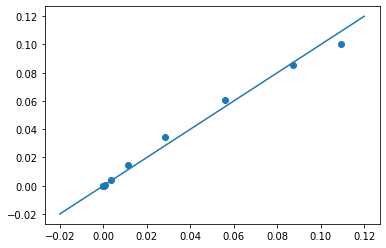

In [19]:
plt.scatter(n_js_table, X_new_arr)
plt.plot([-0.02,0.12], [-0.02,0.12])

## 2. calculate optical depth
###  $\tau_{j+1, j} = TAU(J+1)[n_{J} - n_{J+1}]$
### $TAU=\frac{8\pi^{2}\mu^{2}RN_{CO}}{3hV}$  

In [20]:
tau_list = []
for i in range(len(Js)-1):
    t = TAU * (Js[i] + 1) * (X_new_arr[i] - X_new_arr[i+1])
    tau_list.append(t)
taus = np.array(tau_list)

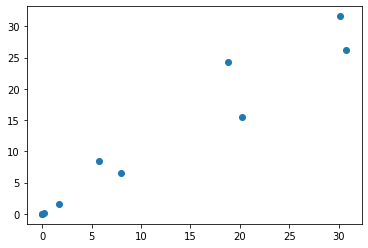

In [21]:
plt.scatter(taus, tau_table)

## 3. excitation temperature
### $T_{J, J-1} = \frac{2hBJ}{kln(\frac{n_{J-1}}{n_{J}})}$

In [28]:
temp_list = []
for i in range(1, len(Js)):
    temp = 2*h*B*Js[i] / (k_b * sp.log(X_new_arr[i-1]/X_new_arr[i]))
    temp_list.append(temp)
temps = np.array(temp_list)

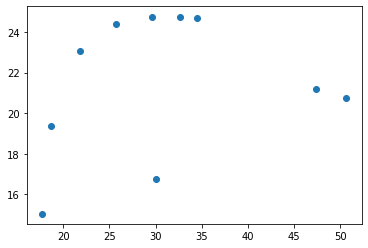

In [29]:
plt.scatter(temps, text_table)

In [34]:
temp_list = []
for i in range(1, len(Js)):
    temp = 2*h*B*Js[i] / (k_b * sp.log(n_js_table[i-1]/n_js_table[i]))
    temp_list.append(temp)
temps = np.array(temp_list)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


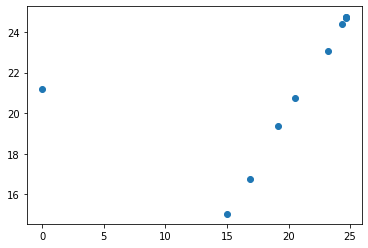

In [35]:
plt.scatter(temps, text_table)

## 4. departure coefficient
#### LTE인 경우 볼츠만 식을 적용할 수 있으므로,

#### $n_{j}^{*} = $

In [ ]:
# n_j_star